In [134]:
# import rasterio as rio
import matplotlib.pyplot as plt 
from matplotlib.colors import Normalize
import numpy as np
import numpy.matlib
from scipy import interpolate
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as st
import scipy
import os, sys, pickle, gzip
import datetime
# import geopy.distance
import xarray as xr
import pandas as pd
# import geopandas as gpd
import shapely.geometry
import shapely.ops
import cartopy
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import itertools
import random
import glob
import xesmf as xe
# import metpy
# from metpy.plots import USCOUNTIES
# from pyts.decomposition import SingularSpectrumAnalysis

import warnings
warnings.filterwarnings('ignore')

In [135]:
run ../util/setupConsole_su

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Figure size 432x288 with 0 Axes>

In [136]:
# dataDir = '/dartfs-hpc/rc/lab/C/CMIG/ecoffel/data/projects/ag6'
dataDir = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/ag6'

In [137]:
crop_models = ['CLM-Crop.Maize', 'EPIC-Boku.Maize', 'EPIC-IIASA.Maize', 'EPIC-TAMU.Maize', 'GEPIC.Maize', 'LPJ-GUESS.Maize', 'LPJmL.Maize', \
              'pAPSIM.Maize', 'pDSSAT.Maize', 'PEGASUS.Maize', 'PEPIC.Maize', 'PRYSBI2.Maize']

In [138]:
latRange = [-90, 90]
lonRange = [0, 360]
regridMesh = xr.Dataset({'lat': (['lat'], np.arange(latRange[0], latRange[1], .5)),
                         'lon': (['lon'], np.arange(lonRange[0], lonRange[1], .5)),})

In [159]:
agmip_yield = xr.Dataset()

In [160]:
for i, model in enumerate(crop_models):
    
    # find current model file name
    fname = glob.glob('%s/agmip/%s/agmerra/*_hist_default_noirr_yield_mai_annual_1980_2010.nc4'%(dataDir, model))
    
    if len(fname) == 0:
        continue
    
    print('opening %s...'%model)
    cur_mdl_yield = xr.open_dataset(fname[0], decode_times=False)
    
    cur_mdl_yield.roll(lon=round(cur_mdl_yield.lon.size/2))
    
    print('loading %s...'%model)
    cur_mdl_yield.load()
    
    print('regridding %s...'%model)
    regridder = xe.Regridder(cur_mdl_yield, regridMesh, 'bilinear')
    regridder.clean_weight_file()
    cur_mdl_yield_regrid = regridder(cur_mdl_yield.yield_mai)
    
    if i == 0:
        timeVar = cur_mdl_yield.time
    
    cur_mdl_yield_regrid_4d = np.full([1, cur_mdl_yield_regrid.shape[0], cur_mdl_yield_regrid.shape[1], cur_mdl_yield_regrid.shape[2]], np.nan)
    cur_mdl_yield_regrid_4d[0, :, :, :] = cur_mdl_yield_regrid
    tempDs_yield = xr.DataArray(data = cur_mdl_yield_regrid_4d,
                          dims   = ['model', 'time', 'lat', 'lon'],
                          coords = {'model':[crop_models[i]], 'time': timeVar, 'lat':regridMesh['lat'], 'lon':regridMesh['lon']})
    if i == 0:
        agmip_yield = tempDs_yield
    else:
        agmip_yield = xr.concat([agmip_yield, tempDs_yield], dim='model')
    
    print()
# cmip6_txx_ds.to_netcdf('cmip6_txx_us.nc')
# cmip6_t50p_ds.to_netcdf('cmip6_t50p_us.nc')
# cmip6_monthly_mean_tx_ds.to_netcdf('cmip6_monthly_mean_tx_us.nc')

opening CLM-Crop.Maize...
loading CLM-Crop.Maize...
regridding CLM-Crop.Maize...
Create weight file: bilinear_360x720_360x720.nc
Remove file bilinear_360x720_360x720.nc

opening EPIC-Boku.Maize...
loading EPIC-Boku.Maize...
regridding EPIC-Boku.Maize...
Create weight file: bilinear_360x720_360x720.nc
Remove file bilinear_360x720_360x720.nc

opening EPIC-IIASA.Maize...
loading EPIC-IIASA.Maize...
regridding EPIC-IIASA.Maize...
Create weight file: bilinear_360x720_360x720.nc
Remove file bilinear_360x720_360x720.nc

opening EPIC-TAMU.Maize...
loading EPIC-TAMU.Maize...
regridding EPIC-TAMU.Maize...
Create weight file: bilinear_360x720_360x720.nc
Remove file bilinear_360x720_360x720.nc

opening GEPIC.Maize...
loading GEPIC.Maize...
regridding GEPIC.Maize...
Create weight file: bilinear_360x720_360x720.nc
Remove file bilinear_360x720_360x720.nc

opening LPJ-GUESS.Maize...
loading LPJ-GUESS.Maize...
regridding LPJ-GUESS.Maize...
Create weight file: bilinear_360x720_360x720.nc
Remove file bil

In [161]:
y = agmip_yield.sel(lat=slice(30,45), lon=slice(255, 285))

In [162]:
for m in range(y.shape[0]):
    X = sm.add_constant(range(y.shape[1]))
    mdl = sm.OLS(np.nanmean(np.nanmean(y[m,:,:,:], axis=2), axis=1), X).fit()
    print(mdl.params, mdl.pvalues[1])


[6.51143187 0.01844019] 0.10338129837999381
[ 7.64446542e+00 -4.29526396e-03] 0.8246485397523862
[6.7211235  0.01139826] 0.3619175427108765
[5.84589452e+00 3.01526611e-03] 0.8704301452265768
[6.47546762 0.01334189] 0.42927744437916326
[2.4897099 0.0073824] 0.03792438813053341
[4.55104512 0.01186989] 0.3268808785774131
[5.73300611 0.01902838] 0.28404966930588416
[9.73836985e+00 7.92866187e-03] 0.787273254607165
[10.87283288  0.02916741] 0.14227616125036968
[ 8.04887691e+00 -4.43219527e-04] 0.9819030007553824


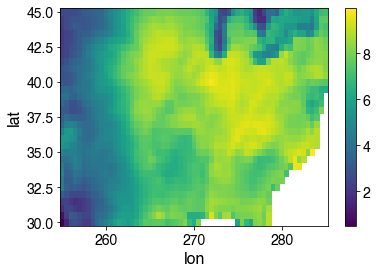

In [163]:
y.mean(dim='time').mean(dim='model').plot()

In [19]:
import climlab
alb = 0.25
#  State variables (Air and surface temperature)
state = climlab.column_state(num_lev=30)
#  Parent model process
rcm = climlab.TimeDependentProcess(state=state)
#  Fixed relative humidity
h2o = climlab.radiation.ManabeWaterVapor(state=state)
#  Couple water vapor to radiation
rad = climlab.radiation.RRTMG(state=state, specific_humidity=h2o.q, albedo=alb)
#  Convective adjustment
conv = climlab.convection.ConvectiveAdjustment(state=state, adj_lapse_rate=6.5)
#  Couple everything together
rcm.add_subprocess('Radiation', rad)
rcm.add_subprocess('WaterVapor', h2o)
rcm.add_subprocess('Convection', conv)
#  Run the model
rcm.integrate_years(1)
#  Check for energy balance
print(rcm.ASR - rcm.OLR)

Data retrieved from http://thredds.atmos.albany.edu:8080/thredds/fileServer/CLIMLAB/ozone/apeozone_cam3_5_54.nc and saved locally.
Integrating for 365 steps, 365.2422 days, or 1 years.
Total elapsed time is 0.9993368783782377 years.
[0.03631771]
